<a href="https://colab.research.google.com/github/Satvik256/Graph-Convolutional-Networks/blob/main/GCN_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch; print(torch.__version__)

1.7.0+cu101


In [ ]:
print(torch.version.cuda)

10.1


In [ ]:
!pip install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
!pip install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
!pip install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
!pip install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 11.9MB 34.5MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 24.3MB 137kB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 21.5MB 3.7MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 6.4MB 8.4MB/s 
     |████████████████████████████████| 184kB 8.3MB/s 
     |████████████████████████████████| 235kB 8.7MB/s 
     |████████████████████████████████| 2.2MB 12.6MB/s 
     |████████████████████████████████| 51kB 8.9MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.6.1-cp36-none-any.whl size=308552 sha256=961101bd6da78d2d1e8ddbfcba2f8f4edef441c2ddd77449ecc2dfb50fe2220f
  Stored in directory: /root/.cache/pip/wheels/e6/25/ea/3d71d2088dccc63214fa59259dcc598ded4150a5f8b41d84ff
Suc

In [ ]:
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader
import torch_geometric.transforms as T
from sklearn.manifold import TSNE

In [ ]:
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__(aggr='add')  # "Add" aggregation
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # Step 1: Add self-loops
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Multiply with weights
        x = self.lin(x)

        # Step 3: Calculate the normalization
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4: Propagate the embeddings to the next layer
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x,
                              norm=norm)

    def message(self, x_j, norm):
        # Normalize node features.
        return norm.view(-1, 1) * x_j

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [ ]:
def plot_dataset(dataset):
    edges_raw = dataset.data.edge_index.numpy()
    edges = [(x, y) for x, y in zip(edges_raw[0, :], edges_raw[1, :])]
    labels = dataset.data.y.numpy()

    G = nx.Graph()
    G.add_nodes_from(list(range(np.max(edges_raw))))
    G.add_edges_from(edges)
    plt.subplot(111)
    options = {
                'node_size': 30,
                'width': 0.2,
    }
    nx.draw(G, with_labels=False, node_color=labels.tolist(), cmap=plt.cm.tab10, font_weight='bold', **options)
    plt.show()

In [ ]:
def test(data, train=True):
    model.eval()

    correct = 0
    pred = model(data).max(dim=1)[1]

    if train:
        correct += pred[data.train_mask].eq(data.y[data.train_mask]).sum().item()
        return correct / (len(data.y[data.train_mask]))
    else:
        correct += pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
        return correct / (len(data.y[data.test_mask]))

In [ ]:
def train(data, plot=False):
    train_accuracies, test_accuracies = list(), list()
    for epoch in range(100):
            model.train()
            optimizer.zero_grad()
            out = model(data)
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            train_acc = test(data)
            test_acc = test(data, train=False)

            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)
            print('Epoch: {:03d}, Loss: {:.5f}, Train Acc: {:.5f}, Test Acc: {:.5f}'.
                  format(epoch, loss, train_acc, test_acc))

    if plot:
        plt.plot(train_accuracies, label="Train accuracy")
        plt.plot(test_accuracies, label="Validation accuracy")
        plt.xlabel("# Epoch")
        plt.ylabel("Accuracy")
        plt.legend(loc='upper right')
        plt.show()

##***CORA DATASET***
we have machine learning papers from seven different areas and want to classify which paper belongs to which. The features of each paper are often occurring words. An edge between two nodes shows that one paper cites the other one. By looking at the dataset we can already see that papers of the same area form a cluster.
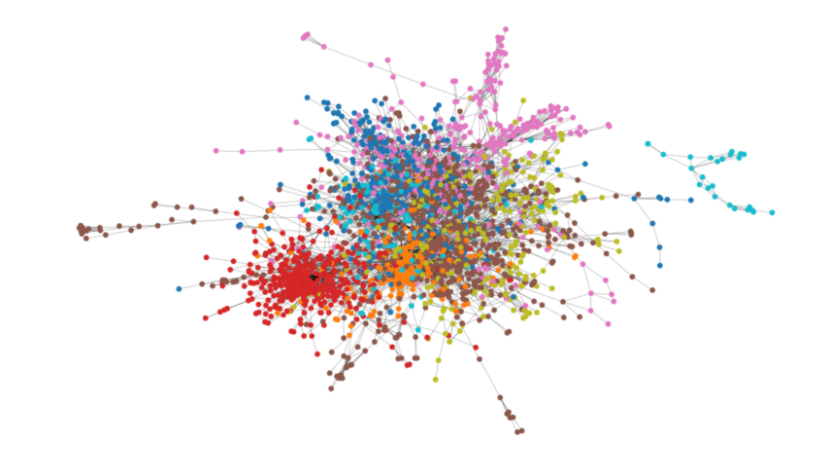

In [ ]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


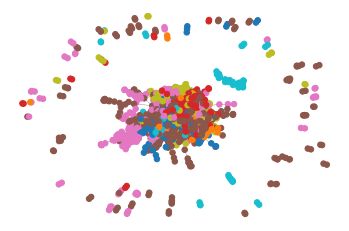

In [ ]:
plot_dataset(dataset)

In [ ]:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Net(dataset).to(device)
    data = dataset[0].to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

Epoch: 000, Loss: 1.95093, Train Acc: 0.39286, Test Acc: 0.23100
Epoch: 001, Loss: 1.88902, Train Acc: 0.47143, Test Acc: 0.30000
Epoch: 002, Loss: 1.81009, Train Acc: 0.66429, Test Acc: 0.46800
Epoch: 003, Loss: 1.72235, Train Acc: 0.73571, Test Acc: 0.59400
Epoch: 004, Loss: 1.62129, Train Acc: 0.82143, Test Acc: 0.65400
Epoch: 005, Loss: 1.51870, Train Acc: 0.82857, Test Acc: 0.68200
Epoch: 006, Loss: 1.41041, Train Acc: 0.87857, Test Acc: 0.69800
Epoch: 007, Loss: 1.30335, Train Acc: 0.92143, Test Acc: 0.72800
Epoch: 008, Loss: 1.21984, Train Acc: 0.93571, Test Acc: 0.75800
Epoch: 009, Loss: 1.09005, Train Acc: 0.94286, Test Acc: 0.77600
Epoch: 010, Loss: 1.00018, Train Acc: 0.95000, Test Acc: 0.78900
Epoch: 011, Loss: 0.90723, Train Acc: 0.95714, Test Acc: 0.79500
Epoch: 012, Loss: 0.83288, Train Acc: 0.96429, Test Acc: 0.80200
Epoch: 013, Loss: 0.75519, Train Acc: 0.97143, Test Acc: 0.80500
Epoch: 014, Loss: 0.61995, Train Acc: 0.97857, Test Acc: 0.81400
Epoch: 015, Loss: 0.61370

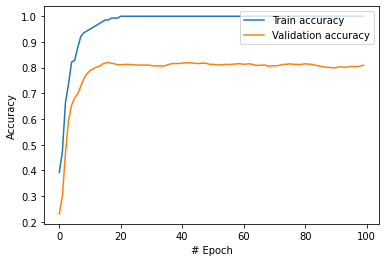

In [ ]:
train(data, plot=True)

In [ ]:
color_list = ["red", "orange", "green", "blue", "purple","brown","yellow"]

loader = DataLoader(dataset, batch_size=64, shuffle=True)
embs = []
colors = []

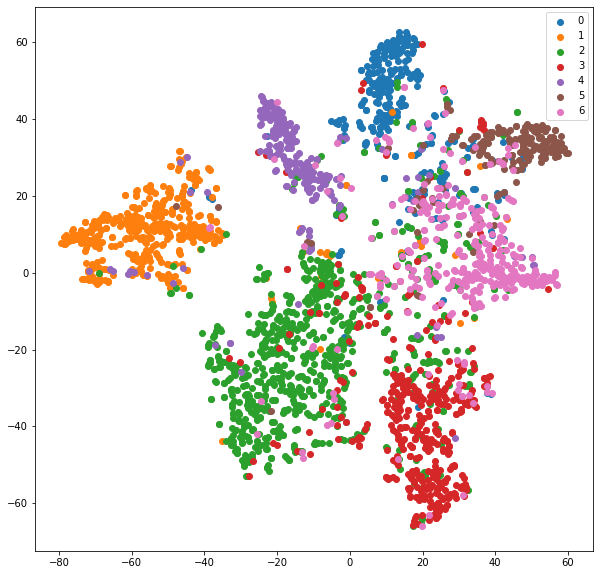

In [ ]:
def plot_tSNE(labels_encoded,x_tsne):
    color_map = np.argmax(labels_encoded, axis=1)
    plt.figure(figsize=(10,10))
    for cl in range(num_classes):
        indices = np.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl)
    plt.legend()
    plt.show()
    
plot_tSNE(labels_encoded,x_tsne)

####**If we plot a t_sne distribution of Fully Connected Neural Network as well,.The t-SNE visualization plot of FCNN hidden layer representations is scattered, which means that FCNN can’t learn the features representations as well as GCN.**
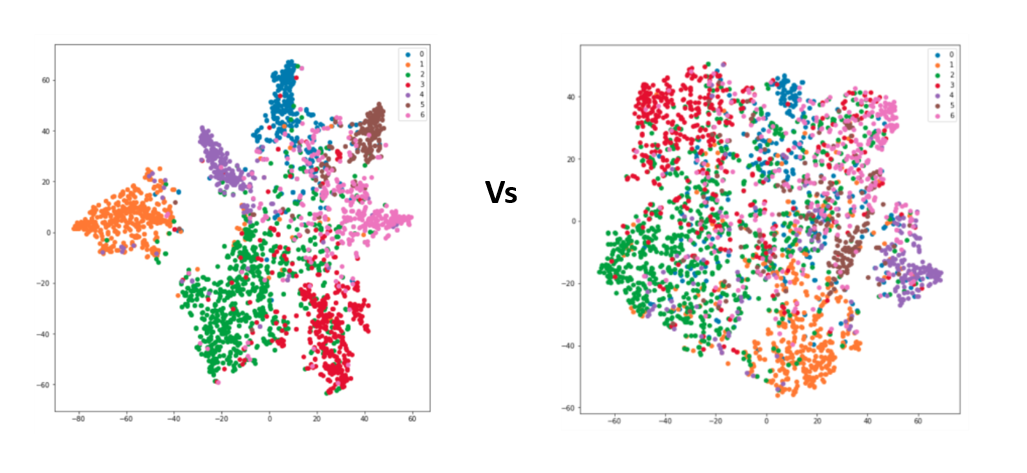

## ##**SOME RESULTS FOR OTHER DATASETS:**
**PubMed Dataset:**
The PubMed Diabetes dataset consists of 19717 scientific publications from PubMed database pertaining to diabetes classified into one of three classes. The citation network consists of 44338 links. Each publication in the dataset is described by a TF/IDF weighted word vector from a dictionary which consists of 500 unique words.

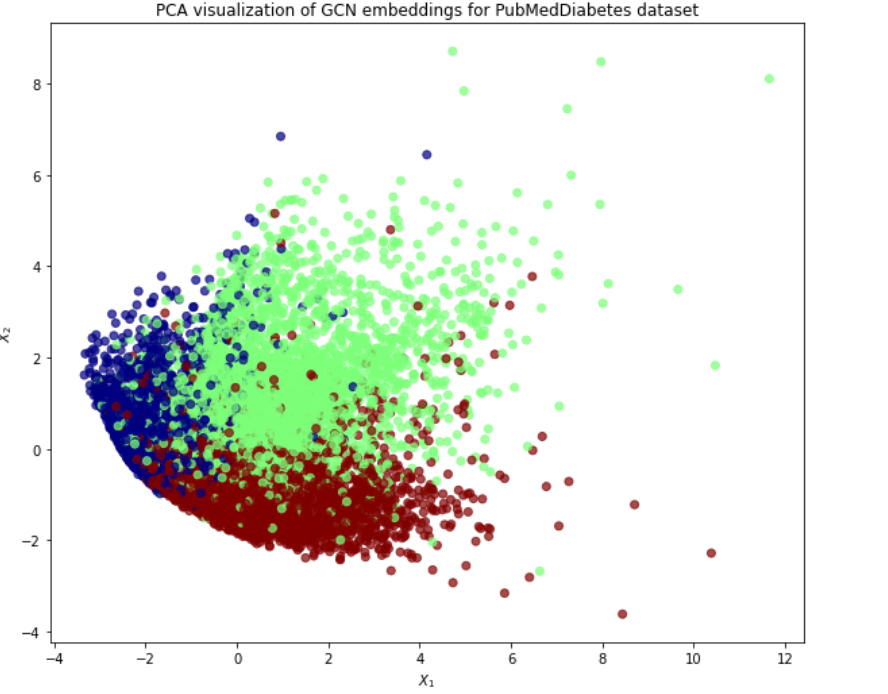
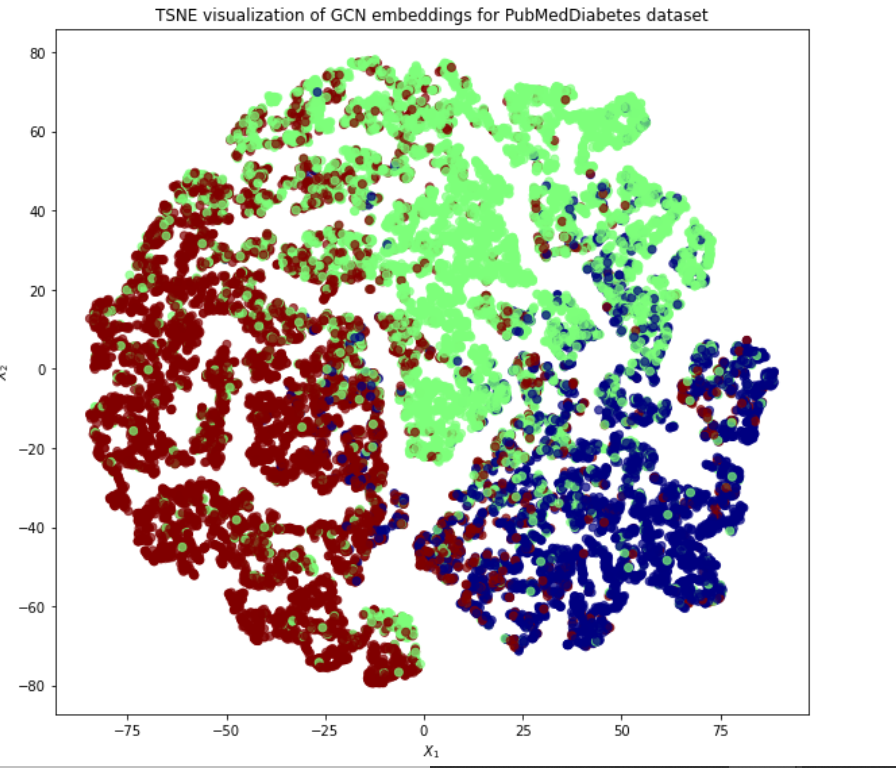

**Citeseer Dataset :**
The CiteSeer dataset consists of 3312 scientific publications classified into one of six classes. The citation network consists of 4732 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 3703 unique words. The README file in the dataset provides more details.
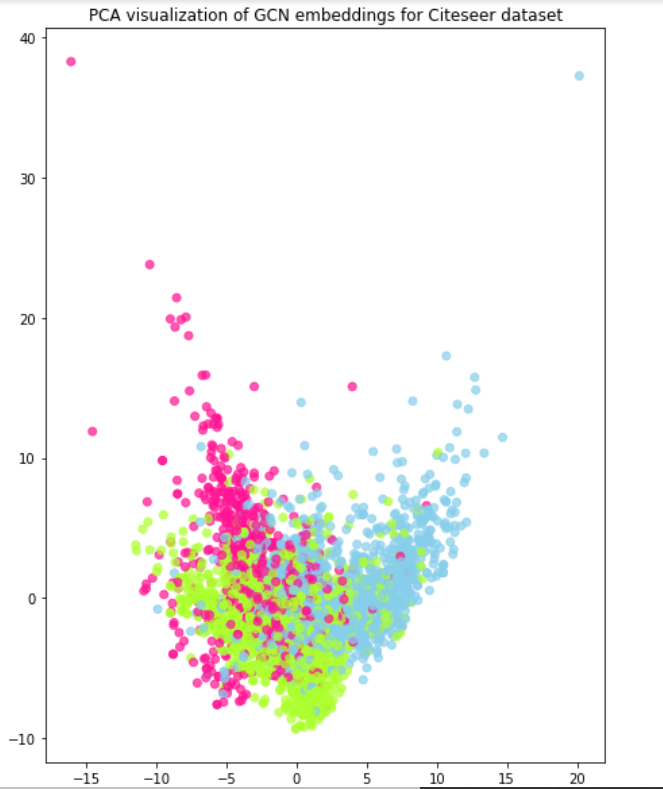
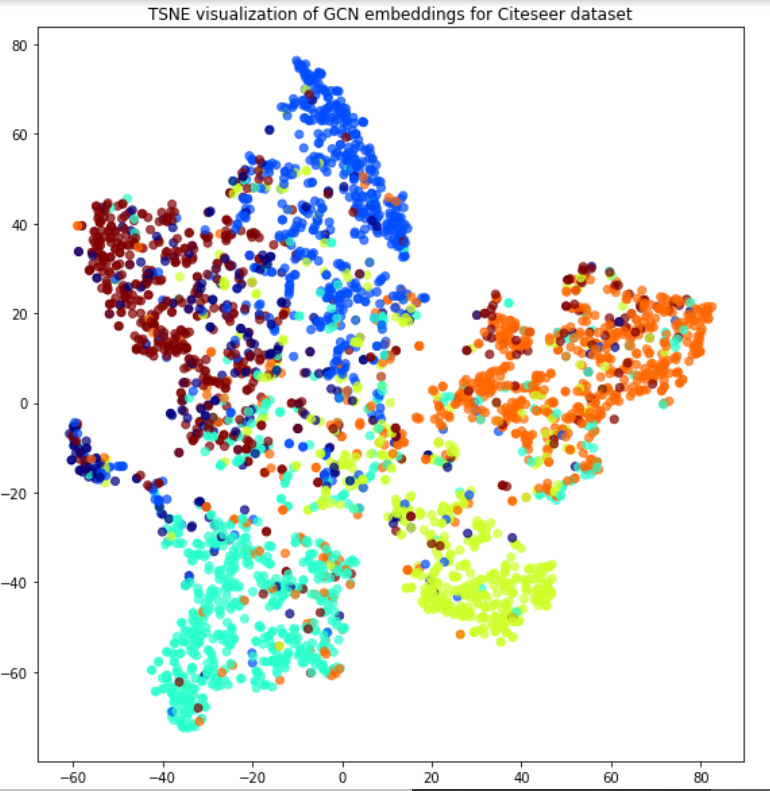